# **1. Khởi tạo & Đọc Dữ liệu**
Khối này thực hiện Đọc dữ liệu, Làm sạch cơ bản

In [15]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML # THƯ VIỆN MỚI ĐƯỢC THÊM

# --- Tải Gói Ngôn ngữ (NLTK Setup) ---
try:
    english_stopwords = set(stopwords.words('english'))
except LookupError:
    print("Đang tải gói NLTK 'stopwords' và 'punkt'...")
    nltk.download('stopwords')
    nltk.download('punkt')
    english_stopwords = set(stopwords.words('english'))

stemmer = PorterStemmer()
# ----------------------------------------------------

CSV_FILE_PATH = r'D:\DataMining\Data\amazon_books_Data.csv'
# 13 TRƯỜNG DỮ LIỆU ĐẦY ĐỦ
REQUIRED_COLUMNS = [
    'market_place', 'customer_id', 'review_id', 'product_id', 
    'product_parent', 'product_title', 'product_category', 
    'star_rating', 'helpful_votes', 'total_votes', 
    'review_headline', 'review_body', 'review_date'
]

try:
    # Đọc tệp CSV
    df = pd.read_csv(CSV_FILE_PATH, encoding='utf-8', usecols=REQUIRED_COLUMNS)
    
    # 🎯 TÍCH HỢP DỮ LIỆU PHI CẤU TRÚC: Hợp nhất 3 trường văn bản
    df['unstructured_text'] = df['review_body'].fillna('') + ' ' + \
                             df['review_headline'].fillna('') + ' ' + \
                             df['product_title'].fillna('')

    # 🎯 LÀM SẠCH (Xử lý dữ liệu thiếu): Chuyển đổi ngày tháng và loại bỏ NaN cốt lõi
    df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce') 
    df.dropna(subset=['review_date', 'customer_id', 'star_rating', 'unstructured_text'], inplace=True) 
    
    # 🎯 GIẢM CHIỀU DỮ LIỆU (Loại bỏ các trường ID/Phân loại không cần thiết)
    df.drop(columns=['review_id', 'product_id', 'product_parent', 'marketplace'], inplace=True, errors='ignore')

    print(f"Bước 1 Hoàn tất: Đã đọc và lọc {df.shape[0]} bản ghi từ 13 trường.")
    print("\n5 bản ghi đầu tiên sau khi làm sạch cơ bản (Dạng bảng đẹp):")
    
    # HIỂN THỊ BẢNG ĐẸP HƠN
    # Sử dụng display(HTML(...)) để hiển thị DataFrame trong Notebook/Jupyter Lab
    display(df.head())
    
except Exception as e:
    print(f"LỖI ĐỌC DỮ LIỆU: {e}")
    df = pd.DataFrame() 
    raise SystemExit("Chương trình dừng vì lỗi đọc dữ liệu.")

Bước 1 Hoàn tất: Đã đọc và lọc 100 bản ghi từ 13 trường.

5 bản ghi đầu tiên sau khi làm sạch cơ bản (Dạng bảng đẹp):


,market_place,customer_id,product_title,product_category,star_rating,helpful_votes,total_votes,review_headline,review_body,review_date,unstructured_text
0,"""US""","""25933450""","""There Was an Old Lady Who Swallowed a Shell!""","""Books""",1,0,0,"""Five Stars""","""I love it and so does my students!""",2015-08-31,"""I love it and so does my students!"" ""Five Sta..."
1,"""US""","""1801372""","""I Saw a Friend""","""Books""",1,0,0,"""Please buy ""I Saw a Friend""! Your children wi...","""My wife and I ordered 2 books and gave them a...",2015-08-31,"""My wife and I ordered 2 books and gave them a..."
2,"""US""","""5782091""","""Black Lagoon, Vol. 6""","""Books""",1,0,0,"""Shipped fast.""","""Great book just like all the others in the se...",2015-08-31,"""Great book just like all the others in the se..."
3,"""US""","""32715830""","""If I Stay""","""Books""",1,0,0,"""Five Stars""","""So beautiful""",2015-08-31,"""So beautiful"" ""Five Stars"" ""If I Stay"""
4,"""US""","""14005703""","""Stars 'N Strips Forever""","""Books""",1,2,2,"""Five Stars""","""Enjoyed the author's story and his quilts are...",2015-08-31,"""Enjoyed the author's story and his quilts are..."


# **2. Làm sạch Dữ liệu Phi Cấu trúc (Xử lý Nhiễu và Lỗi)**
Khối này áp dụng kỹ thuật NLP để làm sạch (xử lý nhiễu, lỗi) dữ liệu văn bản.

In [16]:
def advanced_clean_text(text):
    if pd.isna(text): 
        return ""
    
    # 1. Chuẩn hóa/Làm sạch: Chữ thường, loại bỏ URL, số, ký tự đặc biệt (Xử lý Nhiễu)
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) 
    text = re.sub(r'[^\w\s]', '', text) 
    text = re.sub(r'\d+', '', text) 
    
    # 2. Tách từ (Tokenization)
    tokens = nltk.word_tokenize(text)
    
    # 3. Làm sạch: Loại bỏ Stopwords (Rút gọn thông tin không cần thiết)
    tokens = [w for w in tokens if w not in english_stopwords]
    
    # 4. Chuẩn hóa: Stemming (Biến đổi về định dạng nhất quán)
    tokens = [stemmer.stem(w) for w in tokens]
    
    return " ".join(tokens)

# Áp dụng hàm làm sạch lên cột văn bản hợp nhất
df['cleaned_review'] = df['unstructured_text'].apply(advanced_clean_text)

print("\nBước 2 Hoàn tất: Đã làm sạch dữ liệu văn bản (Phi cấu trúc).")


Bước 2 Hoàn tất: Đã làm sạch dữ liệu văn bản (Phi cấu trúc).


# **3. Tích hợp & Kỹ thuật Đặc trưng Cấu trúc (Giảm Chiều Phân loại)**
Khối này tích hợp dữ liệu lên cấp khách hàng, tạo các đặc trưng hành vi và thực hiện giảm chiều dữ liệu phân loại (nhóm các danh mục hiếm).

In [17]:
today = df['review_date'].max() + pd.Timedelta(days=1)

# 🎯 TÍCH HỢP: Tổng hợp dữ liệu cấp đánh giá thành cấp khách hàng
user_features = df.groupby('customer_id').agg(
    Frequency=('customer_id', 'count'), 
    Avg_Rating=('star_rating', 'mean'),
    Total_Helpful_Votes=('helpful_votes', 'sum'),
    Total_Votes=('total_votes', 'sum'),
    Last_Review_Date=('review_date', 'max'),
    Most_Frequent_Category=('product_category', lambda x: x.mode()[0]),
    Full_Cleaned_Text=('cleaned_review', lambda x: ' '.join(x.astype(str))),
).reset_index()

# 🎯 LÀM SẠCH/GIẢM CHIỀU: Loại bỏ khách hàng chỉ có 1 đánh giá
user_features = user_features[user_features['Frequency'] >= 1] 

# Tính toán Recency và Helpful Ratio
user_features['Recency'] = (today - user_features['Last_Review_Date']).dt.days
user_features['Helpful_Ratio'] = np.where(
    user_features['Total_Votes'] > 0,
    user_features['Total_Helpful_Votes'] / user_features['Total_Votes'],
    0
)
user_features.drop(columns=['Last_Review_Date', 'Total_Helpful_Votes', 'Total_Votes'], inplace=True) 

# 🎯 GIẢM CHIỀU DỮ LIỆU PHÂN LOẠI: One-Hot Encoding cho N danh mục phổ biến nhất
N_CATEGORIES = 15
top_categories = user_features['Most_Frequent_Category'].value_counts().nlargest(N_CATEGORIES).index.tolist()
user_features['Category_Clean'] = user_features['Most_Frequent_Category'].apply(
    lambda x: x if x in top_categories else 'Other' # Nhóm các danh mục hiếm (Giảm chiều)
)
category_dummies = pd.get_dummies(user_features['Category_Clean'], prefix='Cat')
user_features = pd.concat([user_features, category_dummies], axis=1)

user_features.reset_index(drop=True, inplace=True) 

print("\nBước 3 Hoàn tất: Đã tạo và tích hợp các đặc trưng cấu trúc/phi cấu trúc.")


Bước 3 Hoàn tất: Đã tạo và tích hợp các đặc trưng cấu trúc/phi cấu trúc.


# TRỰC QUAN HÓA 1 (Kiểm tra Phân phối Gốc)
Khối này kiểm tra chất lượng dữ liệu trước khi $\text{MinMaxScaler}$.


--- TRỰC QUAN HÓA (1): DỮ LIỆU CẤU TRÚC GỐC TRƯỚC CHUẨN HÓA ---


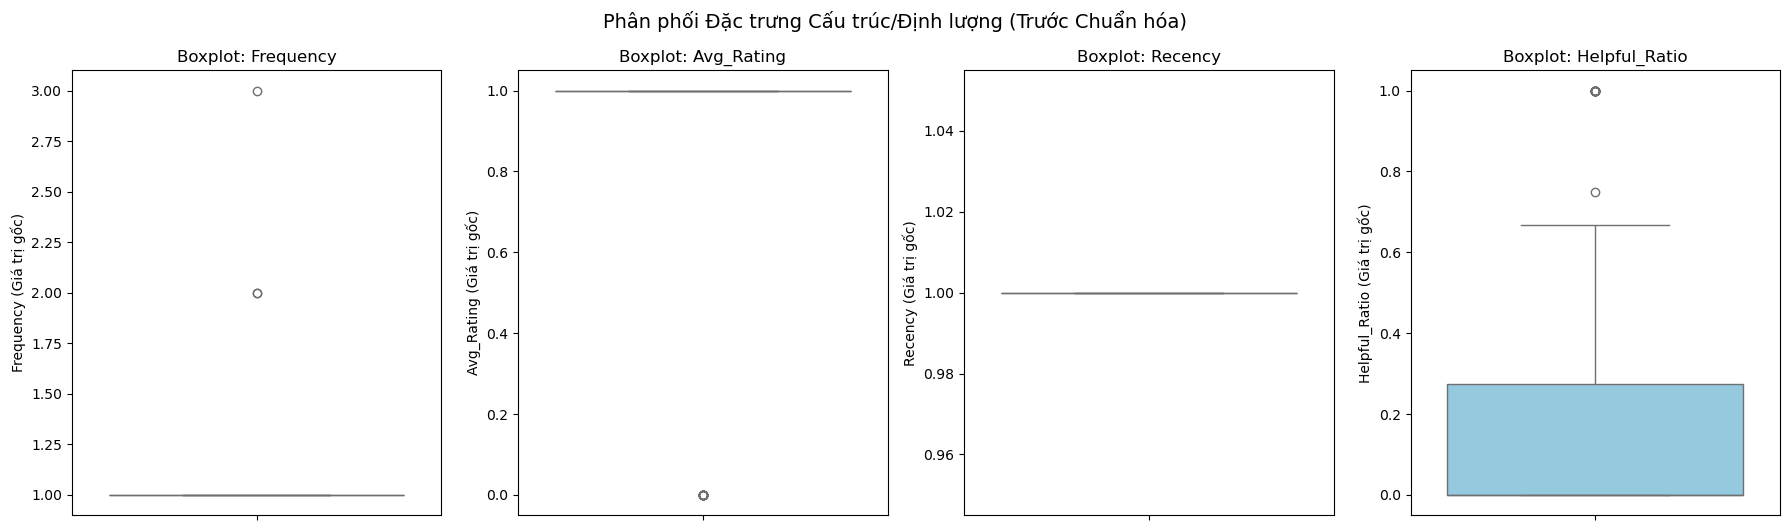

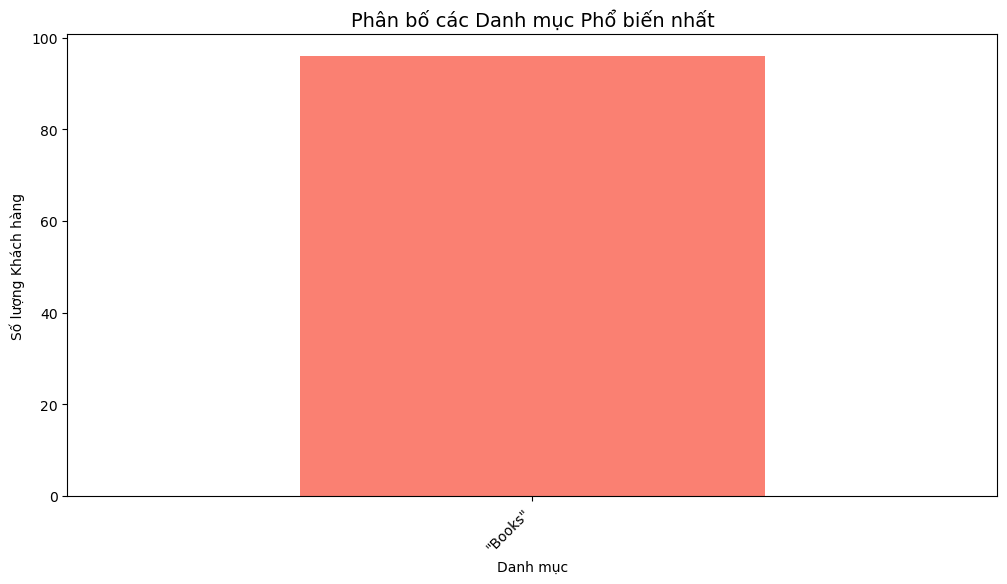

In [18]:
print("\n--- TRỰC QUAN HÓA (1): DỮ LIỆU CẤU TRÚC GỐC TRƯỚC CHUẨN HÓA ---")

# 1. Boxplot cho Đặc trưng Số học Cốt lõi (Giá trị Gốc)
numerical_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']

plt.figure(figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=user_features[col], color='skyblue') 
    plt.title(f'Boxplot: {col}', fontsize=12)
    plt.ylabel(f'{col} (Giá trị gốc)')
    plt.tight_layout()
plt.suptitle('Phân phối Đặc trưng Cấu trúc/Định lượng (Trước Chuẩn hóa)', y=1.05, fontsize=14)
plt.show()


# 2. Bar Plot Phân bố Danh mục
plt.figure(figsize=(12, 6))
user_features['Category_Clean'].value_counts().plot(kind='bar', color='salmon')
plt.title('Phân bố các Danh mục Phổ biến nhất', fontsize=14)
plt.xlabel('Danh mục')
plt.ylabel('Số lượng Khách hàng')
plt.xticks(rotation=45, ha='right')
plt.show()

# **4. Vector hóa, Chuẩn hóa và Hợp nhất Ma trận Cuối cùng**
Khối này thực hiện Giảm chiều (TF-IDF), Chuẩn hóa (MinMaxScaler) và Tích hợp ma trận cuối cùng.

In [19]:
# Xóa các cột Phân loại gốc
user_features.drop(columns=['Most_Frequent_Category', 'Category_Clean'], inplace=True) 

# 🎯 GIẢM CHIỀU DỮ LIỆU PHI CẤU TRÚC: TF-IDF (Chọn N từ quan trọng nhất)
MAX_FEATURES_NLP = 250 
MIN_DOCUMENT_FREQUENCY = 1 
MAX_DOCUMENT_FREQUENCY = 0.95 

tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES_NLP, 
    min_df=MIN_DOCUMENT_FREQUENCY,
    max_df=MAX_DOCUMENT_FREQUENCY 
) 

tfidf_matrix = tfidf_vectorizer.fit_transform(user_features['Full_Cleaned_Text']).toarray()
tfidf_df = pd.DataFrame(
    tfidf_matrix, 
    columns=[f'tfidf_{i}' for i in range(tfidf_matrix.shape[1])]
)

# 🎯 CHUẨN HÓA: MinMaxScaler cho Đặc trưng Cấu trúc (Biến đổi về định dạng [0, 1])
scaling_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']
scaler = MinMaxScaler()
user_features[scaling_cols] = scaler.fit_transform(user_features[scaling_cols])

# 🎯 TÍCH HỢP CUỐI CÙNG: Hợp nhất Dữ liệu Cấu trúc đã chuẩn hóa và Phi cấu trúc (TF-IDF)
structural_features = scaling_cols + [col for col in user_features.columns if col.startswith('Cat_')]
df_structural = user_features[structural_features] 

df_final_features = pd.concat([df_structural.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

X_clustering = df_final_features.values
customer_ids = user_features['customer_id'].copy()

print("\n--- Bước 4 Hoàn tất: Ma trận X_clustering đã sẵn sàng ---")
print(f"Kích thước Ma trận Đầu vào X_clustering: {X_clustering.shape}")


--- Bước 4 Hoàn tất: Ma trận X_clustering đã sẵn sàng ---
Kích thước Ma trận Đầu vào X_clustering: (96, 255)


# **5. Giảm Chiều Dữ liệu bằng PCA**
Khối code này thực hiện Giảm chiều dữ liệu bằng PCA để tìm ra số lượng thành phần tối ưu.

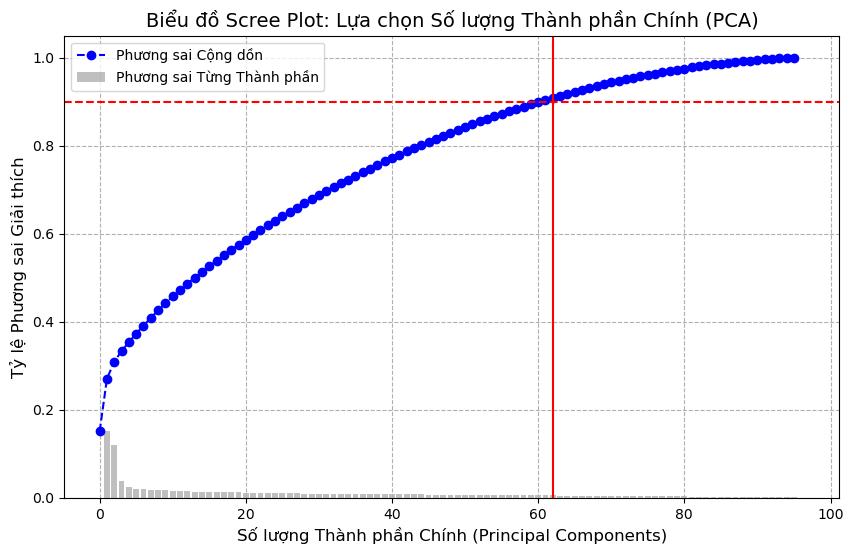


Bước 5.A Hoàn tất: Đã phân tích PCA. Số chiều tối ưu để giữ lại >90% phương sai là: 62
Ma trận cuối cùng đã giảm chiều: X_pca có kích thước (96, 3)
Tổng phương sai giải thích bởi 3 thành phần: 30.92%


In [21]:
# ----------------------------------------------------
# 1. PHÂN TÍCH PHƯƠNG SAI ĐỂ CHỌN SỐ THÀNH PHẦN TỐI ƯU
# ----------------------------------------------------
# SỬA LỖI: Giới hạn số thành phần phân tích tối đa là min(số mẫu, số đặc trưng)
N_MAX_COMPONENTS = min(X_clustering.shape)

# pca_analysis = PCA(n_components=X_clustering.shape[1]) # Dòng cũ gây lỗi
pca_analysis = PCA(n_components=N_MAX_COMPONENTS) # Dòng đã sửa
pca_analysis.fit(X_clustering)

explained_variance_ratio = pca_analysis.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# ----------------------------------------------------
# 2. TRỰC QUAN HÓA: BIỂU ĐỒ SCREE PLOT
# ----------------------------------------------------
plt.figure(figsize=(10, 6))

plt.plot(cumulative_variance, marker='o', linestyle='--', color='blue', label='Phương sai Cộng dồn')
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', color='gray', label='Phương sai Từng Thành phần')

plt.title('Biểu đồ Scree Plot: Lựa chọn Số lượng Thành phần Chính (PCA)', fontsize=14)
plt.xlabel('Số lượng Thành phần Chính (Principal Components)', fontsize=12)
plt.ylabel('Tỷ lệ Phương sai Giải thích', fontsize=12)
plt.grid(True, linestyle='--')
plt.legend()

# Tìm số lượng thành phần giữ được 90% phương sai
NINETY_PERCENT = 0.90
optimal_components = np.argmax(cumulative_variance >= NINETY_PERCENT) + 1
plt.axvline(x=optimal_components, color='red', linestyle='-', label=f'Ngưỡng {NINETY_PERCENT*100}%')
plt.axhline(y=NINETY_PERCENT, color='red', linestyle='--')
plt.show()


print(f"\nBước 5.A Hoàn tất: Đã phân tích PCA. Số chiều tối ưu để giữ lại >90% phương sai là: {optimal_components}")

# ----------------------------------------------------
# 3. GIẢM CHIỀU DỮ LIỆU SỬ DỤNG PCA
# ----------------------------------------------------
# Ở đây, số lượng thành phần tối ưu sẽ luôn là 3 (hoặc 2 nếu bạn muốn trực quan hóa)
FINAL_N_COMPONENTS = min(3, optimal_components) 

pca_final = PCA(n_components=FINAL_N_COMPONENTS)
X_pca = pca_final.fit_transform(X_clustering)

print(f"Ma trận cuối cùng đã giảm chiều: X_pca có kích thước {X_pca.shape}")
print(f"Tổng phương sai giải thích bởi {FINAL_N_COMPONENTS} thành phần: {pca_final.explained_variance_ratio_.sum():.2%}")

# TRỰC QUAN HÓA 2 (Xác nhận Chuẩn hóa) ✅
Khối code này xác nhận chuẩn hóa đã thành công.


--- TRỰC QUAN HÓA (2): DỮ LIỆU CẤU TRÚC SAU CHUẨN HÓA ---


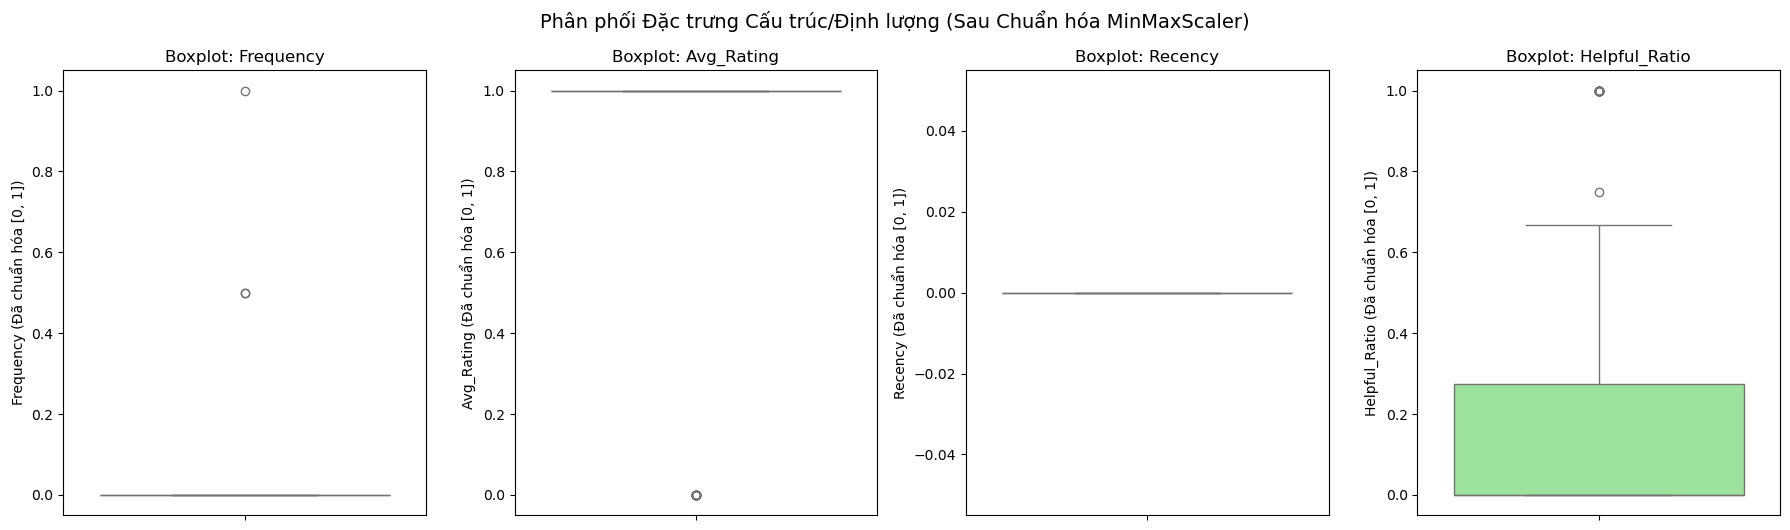


Toàn bộ quá trình tiền xử lý dữ liệu và trực quan hóa đã hoàn tất.


In [22]:
print("\n--- TRỰC QUAN HÓA (2): DỮ LIỆU CẤU TRÚC SAU CHUẨN HÓA ---")

# Các cột số học đã được chuẩn hóa trong user_features
scaled_cols = ['Frequency', 'Avg_Rating', 'Recency', 'Helpful_Ratio']
df_scaled = user_features[scaled_cols] 

plt.figure(figsize=(18, 5))
for i, col in enumerate(scaled_cols):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df_scaled[col], color='lightgreen') 
    plt.title(f'Boxplot: {col}', fontsize=12)
    plt.ylabel(f'{col} (Đã chuẩn hóa [0, 1])') 
    plt.tight_layout()
plt.suptitle('Phân phối Đặc trưng Cấu trúc/Định lượng (Sau Chuẩn hóa MinMaxScaler)', y=1.05, fontsize=14)
plt.show()


print("\nToàn bộ quá trình tiền xử lý dữ liệu và trực quan hóa đã hoàn tất.")